In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numba

In [3]:
# Helper function to display images using matplotlib.
def show_image(image, title="Image"):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
# Defining the image loading function.
def load_image(path):
    image = cv2.imread(path)
    if image is None:
        print("Error: Image not loaded. Check the file path.")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Defining the manual energy computation function.
def compute_energy(image):
    # Converting to grayscale & float for precision.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float64)
    h, w = gray.shape

    # Simple gradient kernels.
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    # Initializing gradient images.
    grad_x = np.zeros((h, w))
    grad_y = np.zeros((h, w))

    # Pading the image to handle boundaries.
    padded = np.pad(gray, ((1,1), (1,1)), mode='edge')

    # Convolving manually.
    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            grad_x[i, j] = np.sum(region * kernel_x)
            grad_y[i, j] = np.sum(region * kernel_y)

    energy = np.abs(grad_x) + np.abs(grad_y)
    return energy

In [5]:
# Optimizing the vertical seam search with Numba (for the dynamic programming step).
@numba.njit
def find_vertical_seam_numba(energy):
    h, w = energy.shape
    cost = energy.copy()
    backtrack = np.zeros((h, w), dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            # For border pixels, use a large number instead of float('inf').
            left = cost[i-1, j-1] if j > 0 else 1e9
            middle = cost[i-1, j]
            right = cost[i-1, j+1] if j < w-1 else 1e9

            # Choose the direction with the smallest cumulative energy.
            if left < middle and left < right:
                offset = -1
                min_val = left
            elif middle < right:
                offset = 0
                min_val = middle
            else:
                offset = 1
                min_val = right

            cost[i, j] += min_val
            backtrack[i, j] = j + offset
    return cost, backtrack

In [6]:
# Extract the seam coordinates from the backtrack matrix.
def get_vertical_seam(backtrack):
    h, w = backtrack.shape
    seam = np.zeros(h, dtype=np.int32)
    # Start from the bottom row.
    j = np.argmin(backtrack[-1])
    seam[h-1] = j
    for i in range(h-1, 0, -1):
        j = backtrack[i, j]
        seam[i-1] = j
    return seam

# Remove the found vertical seam from the image.
def remove_vertical_seam(image, seam):
    h, w, _ = image.shape
    new_image = np.zeros((h, w-1, 3), dtype=np.uint8)
    for i in range(h):
        j = seam[i]
        # Remove the seam pixel for each color channel.
        new_image[i, :, 0] = np.delete(image[i, :, 0], j)
        new_image[i, :, 1] = np.delete(image[i, :, 1], j)
        new_image[i, :, 2] = np.delete(image[i, :, 2], j)
    return new_image

In [7]:
def seam_carving_with_visualization(image, num_seams):
    carved_image = image.copy()
    h, w, _ = image.shape

    # Create an index map to track original column indices.
    index_map = np.tile(np.arange(w), (h, 1))

    # List to store seams in terms of original image coordinates.
    seams_recorded = []

    for _ in range(num_seams):
        energy = compute_energy(carved_image)
        _, backtrack = find_vertical_seam_numba(energy)
        seam = get_vertical_seam(backtrack)

        # Record seam positions using the index_map.
        original_seam = np.array([index_map[i, seam[i]] for i in range(h)])
        seams_recorded.append(original_seam)

        # Remove seam from carved image.
        carved_image = remove_vertical_seam(carved_image, seam)

        # Update index_map: remove the corresponding seam column for each row.
        new_index_map = np.zeros((h, index_map.shape[1]-1), dtype=index_map.dtype)
        for i in range(h):
            new_index_map[i] = np.delete(index_map[i], seam[i])
        index_map = new_index_map

    # Create a visualization image: overlay all recorded seams in red on the original image.
    seam_visualization = image.copy()
    for seam in seams_recorded:
        for i in range(h):
            seam_visualization[i, seam[i]] = [255, 0, 0]  # Mark seam pixel in red

    return carved_image, seam_visualization

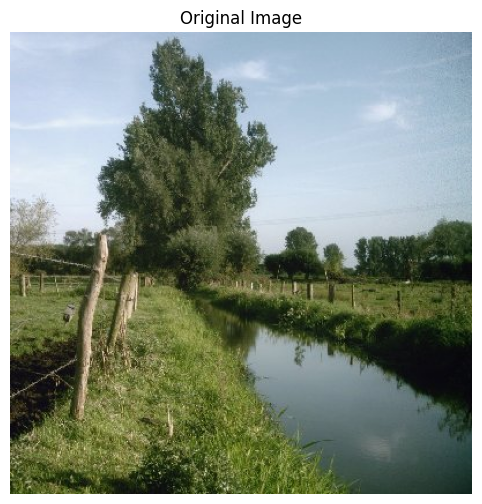

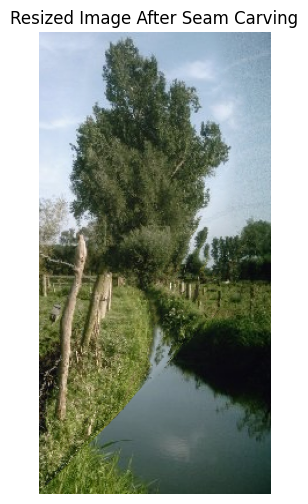

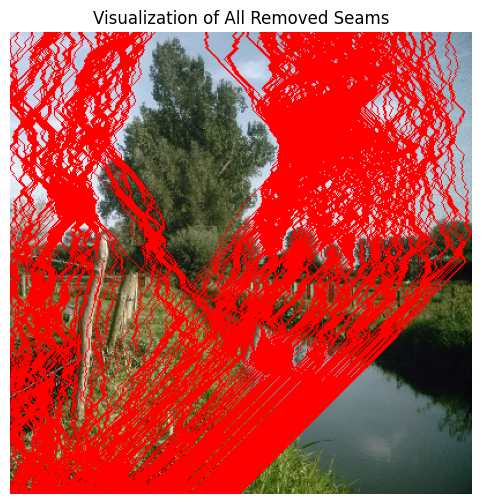

In [8]:
# Set your image path from Google Drive.
image_path = "/content/Hofflöth(TöVo-Clörath)-2(400x400).jpg"
image = load_image(image_path)

if image is not None:
    show_image(image, title="Original Image")

    # Define the number of seams to remove to reduce the width by half.
    num_seams = image.shape[1] // 2

    # Perform seam carving and obtain both the resized image and the seam visualization.
    resized_image, seam_vis = seam_carving_with_visualization(image, num_seams)

    show_image(resized_image, title="Resized Image After Seam Carving")
    show_image(seam_vis, title="Visualization of All Removed Seams")